# V10 MIITS analysis for RRR = 131 / Central Coils

Imports

In [1]:
import numpy as _np
from matplotlib import pyplot as _plt
import quench as _quench
import detection as _detection
import materials as _materials

Simulation for

- Model V10 / Central Coils
- Iop = 236.2 A / 300 A
- Rdump = 0.96 ohm ohm
- t_det = 100 ms
- t_valid = 40 ms
- t_act = 12 ms

In [9]:
# SWLS - Model V10.0
Tc = 9.2
Tcs = 6.1
# Wire measured by SUP
s_cu = 2.76144e-7
s_nbti = 2.99794e-7
s_insulator = 0
RRR = 131
t_valid = 0.04
t_act = 0.012
ps_delay = 0.07 # seg
max_ps_voltage = 10 # V
#V_fw_diode = 0.8 # freewheeling diode fwd voltage
V_fw_diode = 0.0 # freewheeling diode fwd voltage
magnet_vol = 564 * (s_cu + s_nbti)
vdet = 0.1 # V
Bmax = 5.3 # T
L_cte = 0.096 # H
#L_I = {
#    0.5 : 5.5871,
#    1.0 : 2.8398,
#    5.0 : 0.6421,
#    10.0 : 0.3675,
#    22.8 : 0.2137,
#    45.6 : 0.1543,
#    68.4 : 0.1350,
#    91.2 : 0.1258,
#    114.0 : 0.1206,
#    136.8 : 0.1174,
#    159.6 : 0.1153,
#    182.4 : 0.1140,
#    205.2 : 0.1131,
#    228.0 : 0.1126,
#    250.0 : 0.1123,
#    300.0 : 0.1122,
#}
L_I = {
    236.2 : 0.096
}

# Wilson simulation parameters
time_step_1 = 0.00001
time_step_2 = 0.001
t_switch_time_step = 0.005
alpha = 0.03
use_magnetoresist=True
geometry = 'line'
curr_tol = 1

# Simulation scenarios
#scenario_Iop = [236.2, 300]
scenario_Iop = [300]
#scenario_Rdump = [22/25, 24/25, 32/25]
scenario_Rdump = [0.56]
#scenario_Top = [4.2, 5]
scenario_Top = [4.2]
#scenario_B = _np.linspace(0, Bmax, 6, endpoint=True)
scenario_B = [Bmax]

hot_spot_results = []

dict_scwire = {}
dict_scwire['Iop'] = scenario_Iop[0]
dict_scwire['B'] = Bmax
dict_scwire['Top'] = scenario_Top[0]
dict_scwire['Tc'] = Tc
dict_scwire['Tcs'] = Tcs
dict_scwire['RRR'] = RRR
dict_scwire['ratio_cu_sc'] = s_cu/s_nbti
dict_scwire['d_cond'] = 8.5633e-4
dict_scwire['L'] = L_I

counter = 0
# Hot-spot by MIITS
scwire = _materials.SCWire(dict_scwire)
for Iop in scenario_Iop:
    for B in scenario_B:
        for Rdump in scenario_Rdump:
            for Top in scenario_Top:
                print('counter={}'.format(counter))
                counter += 1
                Jo = Iop/_np.add(s_cu, s_nbti)
                Jo_mm2 = Jo*1e-6
                Tcs = scwire.calc_current_sharing_temp(Jo_mm2, B)
                Tjoule = _np.divide(_np.add(Tc, Tcs), 2)
                if Top >= Tcs:
                    raise ValueError('Tcs cannot be smaller than Top')
                # calculate average heat capacity
                C_avg = _quench.composite_vol_specific_heat_sc(
                    s_cu, s_nbti, Tjoule, Top, B
                )
                rho = _quench.composite_resistivity(
                    Tjoule, s_cu, s_nbti, RRR, B,
                    is_sc=False, use_magnetoresist=True
                )
                k_avg=_quench.composite_thermal_conductivity(
                    copper_area=s_cu, nbti_area=s_nbti, T2=Tjoule,
                    T1=Top, RRR=RRR
                    )
                vq = _detection.calc_prop_velocity(
                    Jo=Jo, C=C_avg, rho=rho, k=k_avg, Tjoule=Tjoule,
                    Top=Top, method='adiabatic'
                    )
                t_det = _detection.calc_detection_time(
                    vq, rho, vdet=vdet, Io=Iop, Acu=s_cu
                    )
                t_switch = t_det + t_valid + t_act
                t_max = _quench.calc_hot_spot(
                    copper_area=s_cu,
                    nbti_area=s_nbti,
                    I_op=Iop,
                    tau=L_cte/Rdump,
                    t_switch=t_switch,
                    RRR=RRR,
                    B=B,
                    )
                hot_spot_results.append((Iop, Rdump, Top, B, C_avg, rho, k_avg, vq, t_switch, t_max))

# print hot-spot results
print(hot_spot_results)


counter=0
[(300, 0.665, 4.2, 5.3, 8460.913576439874, 6.785096046587569e-10, 612.0351395107585, 20.88835556981339, 0.05849462538015421, 105.09999999999964)]


# Worst-case scenario Rdump optimization
Decrease Rdump value and calculate corresponding hot-spot temperature
for the worst-case scenario

In [3]:
hot_spot_results = []

# Worst hot-spot scenario by MIITS
worst_Iop = scenario_Iop[1]
worst_Top = scenario_Top[0]
worst_B = Bmax
best_Rdump = max(scenario_Rdump)
counter = 0

# decrease dump in 2% steps
for Rdump in _np.linspace(best_Rdump, 0, 50):
    print('counter={}'.format(counter))
    counter += 1
    Jo = worst_Iop/_np.add(s_cu, s_nbti)
    Jo_mm2 = Jo*1e-6
    Tcs = scwire.calc_current_sharing_temp(Jo_mm2, worst_B)
    Tjoule = _np.divide(_np.add(Tc, Tcs), 2)
    if worst_Top >= Tcs:
        raise ValueError('Tcs cannot be smaller than Top')
    # calculate average heat capacity
    C_avg = _quench.composite_vol_specific_heat_sc(
        s_cu, s_nbti, Tjoule, worst_Top, worst_B
    )
    rho = _quench.composite_resistivity(
        Tjoule, s_cu, s_nbti, RRR, worst_B,
        is_sc=False, use_magnetoresist=True
    )
    k_avg=_quench.composite_thermal_conductivity(
        copper_area=s_cu, nbti_area=s_nbti, T2=Tjoule,
        T1=worst_Top, RRR=RRR
        )
    vq = _detection.calc_prop_velocity(
        Jo=Jo, C=C_avg, rho=rho, k=k_avg, Tjoule=Tjoule,
        Top=worst_Top, method='adiabatic'
        )
    t_det = _detection.calc_detection_time(
        vq, rho, vdet=vdet, Io=worst_Iop, Acu=s_cu
        )
    t_switch = t_det + t_valid + t_act
    t_max = _quench.calc_hot_spot(
        copper_area=s_cu,
        nbti_area=s_nbti,
        I_op=worst_Iop,
        tau=L_cte/Rdump,
        t_switch=t_switch,
        RRR=RRR,
        B=worst_B,
        )
    hot_spot_results.append((worst_Iop, Rdump, worst_Top, worst_B, C_avg, rho, k_avg, vq, t_switch, t_max))


counter=0
counter=1
counter=2
counter=3
counter=4
counter=5
counter=6
counter=7
counter=8
counter=9
counter=10
counter=11
counter=12
counter=13
counter=14
counter=15
counter=16
counter=17
counter=18
counter=19
counter=20
counter=21
counter=22
counter=23
counter=24
counter=25
counter=26
counter=27
counter=28
counter=29
counter=30
counter=31
counter=32
counter=33
counter=34
counter=35
counter=36
counter=37
counter=38
counter=39
counter=40
counter=41
counter=42
counter=43
counter=44
counter=45
counter=46
counter=47
counter=48
counter=49


C:\Users\andrei.pereira\AppData\Local\Temp\ipykernel_6264\1982960759.py:44: RuntimeWarning: divide by zero encountered in double_scalars
  tau=L_cte/Rdump,


Plot hot-spot temperature for different dump values
and indicate optimal value

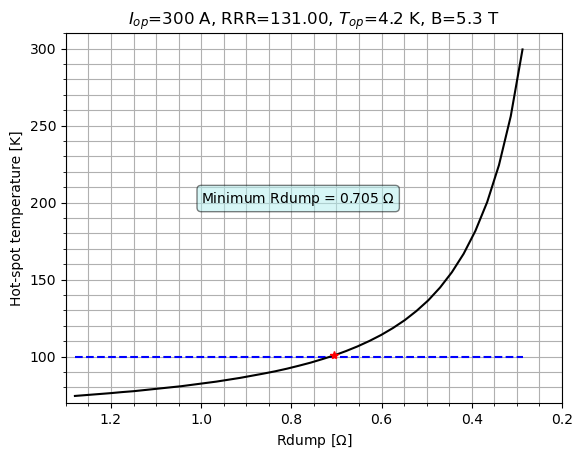

In [8]:
# reference hot-spot temperature
T_ref = 100 # K
# Rdump
data_x = _np.array(hot_spot_results)[:, 1]
# hot-spot
data_y = _np.array(hot_spot_results)[:, -1]
# remove None elements from data
invalid_idxs = _np.where(data_y == None)
data_x = _np.delete(data_x, invalid_idxs)
data_y = _np.delete(data_y, invalid_idxs)
# find optimal dump value
optimal_idx = _np.argmin([abs(d) for d in (data_y - T_ref)])

# plot data
fig, ax1 = _plt.subplots()
# plot reference temp line
ax1.plot(data_x, _np.full(data_x.size, T_ref), 'b--')
# plot data
ax1.plot(data_x, data_y, 'k-')
# plot optimal point
ax1.plot(data_x[optimal_idx], data_y[optimal_idx], 'r*')
ax1.set_xlabel('Rdump [$\Omega$]')
ax1.set_ylabel('Hot-spot temperature [K]', color='k')
ax1.set_ylim([70, 310])
ax1.set_xlim([1.3, 0.2])
_plt.minorticks_on()
_plt.grid(which='both', axis='both')
_plt.title(
    '$I_{{op}}$={} A, RRR={:.2f}, $T_{{op}}$={} K, B={} T'.format(
        worst_Iop,
        RRR,
        worst_Top,
        worst_B
        )
    )
custom_box = dict(boxstyle='round', facecolor='paleturquoise', alpha=0.5)
_plt.text(1.0,200,
    'Minimum Rdump = {:.3f} $\Omega$'.format(data_x[optimal_idx]),
    bbox=custom_box)
_plt.show()

# Wilson quench propagation simulations for main scenarios

In [4]:
# scenario 1
scenario_1 = {}
scenario_1['Iop'] = 300
scenario_1['Rdump'] = scenario_Rdump[0]
scenario_1['Top'] = 5
scenario_1['B'] = 5.3
# scenario 2
scenario_2 = {}
scenario_2['Iop'] = 300
scenario_2['Rdump'] = scenario_Rdump[0]
scenario_2['Top'] = 4.2
scenario_2['B'] = 5.3
# scenario 3
scenario_3 = {}
scenario_3['Iop'] = 300
scenario_3['Rdump'] = scenario_Rdump[0]
scenario_3['Top'] = 5
scenario_3['B'] = 0.0
# scenario 4
scenario_4 = {}
scenario_4['Iop'] = 228
scenario_4['Rdump'] = scenario_Rdump[1]
scenario_4['Top'] = 5
scenario_4['B'] = 5.3
scenarios = [scenario_1, scenario_2, scenario_3, scenario_4]

for scenario in scenarios:
    Jo = scenario['Iop']/_np.add(s_cu, s_nbti)
    Jo_mm2 = Jo*1e-6
    Tcs = scwire.calc_current_sharing_temp(
        Jo_mm2, scenario['B']
        )
    # Wilson simulation
    [
        R, I, Vq, Ve, Vc, Vl, Vnz, Eq, Eps, Tmax, Tavg,
            final_zone_transv_radius, final_zone_long_radius,
            time_axis, iter_cnt
        ] = _quench.simple_quench_propagation(
        I_op=scenario['Iop'], T_cs=Tcs, T_op=scenario['Top'],
        copper_area=s_cu, nbti_area=s_nbti, insulator_area=s_insulator,
        inductanceI=L_I, magnet_vol=magnet_vol, t_valid=t_valid,
        t_act=t_act, det_tresh=vdet, R_dump=scenario['Rdump'],
        time_step_1=time_step_1, time_step_2=time_step_2,
        switch_time_step=t_switch_time_step, RRR=RRR, B=scenario['B'],
        alpha=alpha, tolerance=curr_tol, geometry=geometry,
        V_ps_max = max_ps_voltage, t_ps=ps_delay,
        V_fw_diode=V_fw_diode, use_magnetoresist=use_magnetoresist,
        print_results=False
        )
    scenario['results'] = {
        'R' : R, 'I' : I, 'Vq' : Vq, 'Ve' : Ve, 'Vc' : Vc, 'Vl' : Vl,
        'Vnz' : Vnz, 'Eq' : Eq, 'Eps' : Eps, 'Tmax' : Tmax, 'Tavg' : Tavg,
        'final_zone_transv_radius' : final_zone_transv_radius,
        'final_zone_long_radius' : final_zone_long_radius,
        'time_axis' : time_axis, 'iter_cnt' : iter_cnt,
    }

num iter = 1
max temp = 7.989338542938784
Iop = 300.0


num iter = 2
max temp = 8.163086299114239
Iop = 300.0


num iter = 3
max temp = 8.328563168356798
Iop = 300.0


num iter = 4
max temp = 8.48665403435152
Iop = 300.0


num iter = 5
max temp = 8.638140771486217
Iop = 300.0


num iter = 6
max temp = 8.783677698353479
Iop = 300.0


num iter = 7
max temp = 8.923818967123351
Iop = 300.0


num iter = 8
max temp = 9.059038810016588
Iop = 300.0


num iter = 9
max temp = 9.189746799926308
Iop = 300.0


num iter = 10
max temp = 9.316299551065242
Iop = 300.0


num iter = 11
max temp = 9.439009826576637
Iop = 300.0


num iter = 12
max temp = 9.558153723754856
Iop = 300.0


num iter = 13
max temp = 9.673976411417744
Iop = 300.0


num iter = 14
max temp = 9.786696761273607
Iop = 300.0


num iter = 15
max temp = 9.896511123531667
Iop = 300.0


num iter = 16
max temp = 10.003596432642075
Iop = 300.0


num iter = 17
max temp = 10.108102624758713
Iop = 300.0


num iter = 18
max temp = 10.20990512593

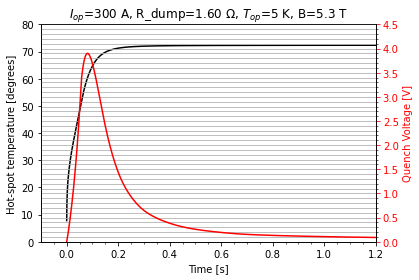

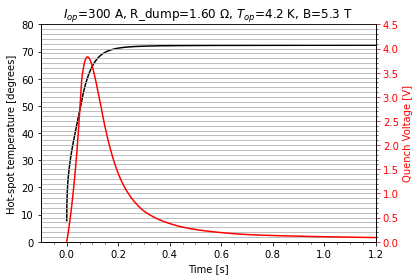

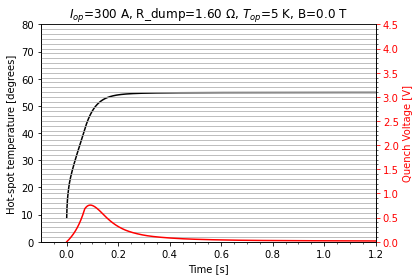

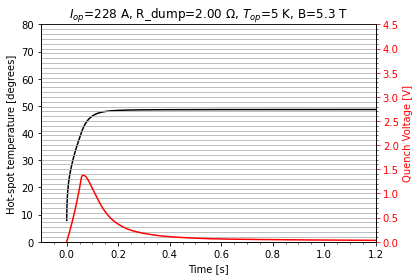

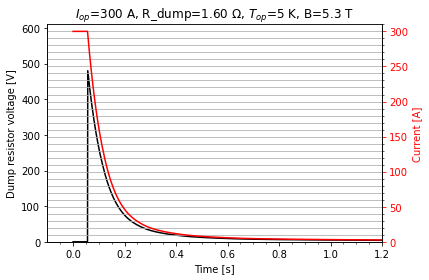

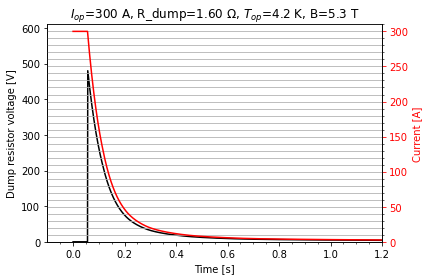

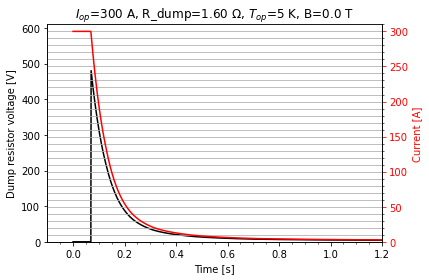

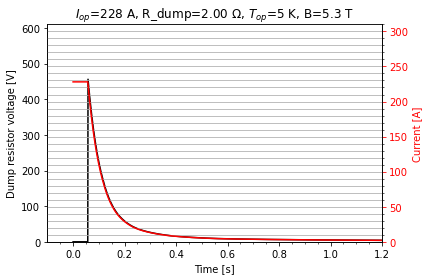

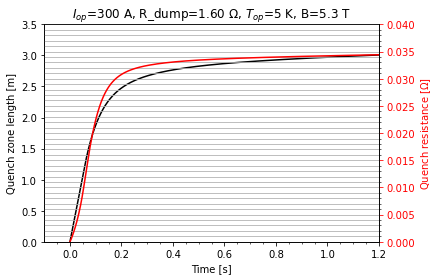

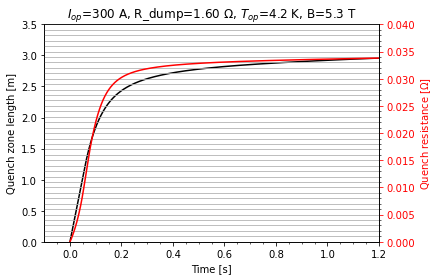

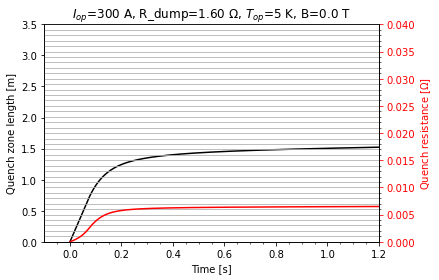

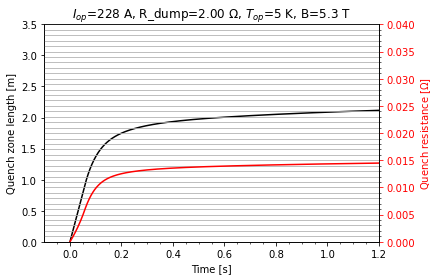

In [8]:
# plot hot-spot temp and quench voltage
for scenario in scenarios:
    data = scenario['results']
    fig, ax1 = _plt.subplots()
    ax2 = ax1.twinx()
    ax1.plot(data['time_axis'], data['Tmax'], 'k-')
    ax2.plot(data['time_axis'], data['Vq'], 'r-')
    ax1.set_xlabel('Time [s]')
    ax1.set_ylabel('Hot-spot temperature [K]', color='k')
    ax2.set_ylabel('Quench Voltage [V]', color='r')
    ax1.set_ylim([0, 80])
    #ax1.set_xlim([-0.1, 1.2])
    ax2.set_ylim([0, 4.5])
    ax2.tick_params(axis='y', colors='r')
    _plt.minorticks_on()
    _plt.grid(which='both', axis='both')
    _plt.title(
        '$I_{{op}}$={} A, R_dump={:.2f} $\Omega$, $T_{{op}}$={} K, B={} T'.format(
            scenario['Iop'],
            scenario['Rdump'],
            scenario['Top'],
            scenario['B']
            )
        )
    _plt.show()

# plot dump voltage and current decay
for scenario in scenarios:
    data = scenario['results']
    fig, ax1 = _plt.subplots()
    ax2 = ax1.twinx()
    ax1.plot(data['time_axis'], data['Ve'], 'k-')
    ax2.plot(data['time_axis'], data['I'], 'r-')
    ax1.set_xlabel('Time [s]')
    ax1.set_ylabel('Dump resistor voltage [V]', color='k')
    ax2.set_ylabel('Current [A]', color='r')
    ax1.set_ylim([0, 610])
    ax1.set_xlim([-0.1, 1.2])
    ax2.set_ylim([0, 310])
    ax2.tick_params(axis='y', colors='r')
    _plt.minorticks_on()
    _plt.grid(which='both', axis='both')
    _plt.title(
        '$I_{{op}}$={} A, R_dump={:.2f} $\Omega$, $T_{{op}}$={} K, B={} T'.format(
            scenario['Iop'],
            scenario['Rdump'],
            scenario['Top'],
            scenario['B']
            )
        )
    _plt.show()

# plot quench zone length and quench resistance
for scenario in scenarios:
    data = scenario['results']
    fig, ax1 = _plt.subplots()
    ax2 = ax1.twinx()
    ax1.plot(data['time_axis'], data['final_zone_long_radius'], 'k-')
    ax2.plot(data['time_axis'], data['R'], 'r-')
    ax1.set_xlabel('Time [s]')
    ax1.set_ylabel('Quench zone length [m]', color='k')
    ax2.set_ylabel('Quench resistance [$\Omega$]', color='r')
    ax2.tick_params(axis='y', colors='r')
    ax1.set_ylim([0, 3.5])
    ax1.set_xlim([-0.1, 1.2])
    ax2.set_ylim([0, 0.04])
    _plt.minorticks_on()
    _plt.grid(which='both', axis='both')
    _plt.title(
        '$I_{{op}}$={} A, R_dump={:.2f} $\Omega$, $T_{{op}}$={} K, B={} T'.format(
            scenario['Iop'],
            scenario['Rdump'],
            scenario['Top'],
            scenario['B']
            )
        )
    _plt.show()

In [10]:
_np.savetxt('Ve_vs_time.txt', _np.c_[time_axis, Ve], delimiter=', ')
_np.savetxt('R_vs_time.txt', _np.c_[time_axis, R], delimiter=', ')
_np.savetxt('I_vs_time.txt', _np.c_[time_axis, I], delimiter=', ')
_np.savetxt('Vq_vs_time.txt', _np.c_[time_axis, Vq], delimiter=', ')
_np.savetxt('Vc_vs_time.txt', _np.c_[time_axis, Vc], delimiter=', ')
_np.savetxt('Vl_vs_time.txt', _np.c_[time_axis, Vl], delimiter=', ')
_np.savetxt('Vnz_vs_time.txt', _np.c_[time_axis, Vnz], delimiter=', ')
_np.savetxt('Eq_vs_time.txt', _np.c_[time_axis, Eq], delimiter=', ')
_np.savetxt('Eps_vs_time.txt', _np.c_[time_axis, Eps], delimiter=', ')
_np.savetxt('Tmax_vs_time.txt', _np.c_[time_axis, Tmax], delimiter=', ')
_np.savetxt('Tavg_vs_time.txt', _np.c_[time_axis, Tavg], delimiter=', ')
_np.savetxt('final_zone_transv_radius_vs_time.txt', _np.c_[time_axis, final_zone_transv_radius], delimiter=', ')
_np.savetxt('final_zone_long_radius_vs_time.txt', _np.c_[time_axis, final_zone_long_radius], delimiter=', ')
